<a href="https://colab.research.google.com/github/torodriguezt/Vision_Artificial/blob/main/FinalTrabajoVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1><center>Trabajo Final Visión Artificial </center></h1>**

**<h1><center> 2022-2s </center></h1>**
---


---


# Programa para reconocer si la imagen es una Pizza

---


## Integrantes:

*   Juan Alejandro Espinosa Cáceres
*   Andrés Felipe Rendón Henao
*   Jose Adolfo Martínez Rodríguez
*   Juan Sebastián Herrera Gómez
*   Tomás Rodríguez Taborda




Desarrollaremos el programa para el reconocimiento de pizzas con el dataset [Pizza or Not Pizza?](https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza) obtenido de [Kaggle](https://www.kaggle.com/) el cual esta compuesto por casi 2000 imágenes clasificadas en pizzas y no pizzas de manera equitativa. Este dataset hace parte de uno mucho más grande y con mayor variedad de comida llamado [Food-101](https://www.kaggle.com/datasets/dansbecker/food-101)

## Importamos Librerías

In [ ]:
import math
import pandas as pd
import numpy as np
import cv2
import os
import seaborn as sns
from skimage import morphology
from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import skimage.morphology as morph
from google.colab import drive

### Cargamos las imágenes desde Drive

In [ ]:
drive.mount("/content/drive")
path_pizza = "/content/drive/MyDrive/Vision/pizza_not_pizza/pizza"
path_not_pizza = "/content/drive/MyDrive/Vision/pizza_not_pizza/not_pizza"

Mounted at /content/drive


La siguiente función nos facilitará la lectura de imágenes durante el desarrollo del trabajo

In [ ]:
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

Guardamos en una una lista las pizzas y en otra las no pizzas, lo anterior nos permitirá poder acceder a cada una de las imágenes de una manera mucho más sencilla y saber en cuales hay problemas de lectura

In [ ]:
# Funcion para la obtencion de datos
def get_images(path, mode = "color"):
  data = []
  path_invalid_images = []
  list_directory = sorted(os.listdir(path))
  for img_path in list_directory:
    try:
      img = img_read(os.path.join(path, img_path), mode)
      img_resize = cv2.resize(img, (100, 100))
      data.append(img_resize)
    except:
      # Si la imagen es invalida 
      # Se agrega su path
      path_invalid_images.append(img_path)
  # Se retorna las imagenes y la ruta de las imagenes no cargadas
  return data, path_invalid_images

## Lectura de imágenes

In [ ]:
# Lectura de imagenes a color
pizzas_color, _ = get_images(path_pizza)
not_pizzas_color, _ = get_images(path_not_pizza)

pizzas_color_copy = pizzas_color.copy()
not_pizzas_color_copy = not_pizzas_color.copy()

# Total de imagenes:
total_images = pizzas_color_copy + not_pizzas_color_copy

In [ ]:
# Lectura de imagenes en escala de gris
pizzas, _= get_images(path_pizza, "gray")
not_pizzas, _ = get_images(path_not_pizza, "gray")

pizzas = np.array(pizzas)
not_pizzas = np.array(not_pizzas)

### Miramos como esta compuesto nuestro dataset

Realizamos una lectura de las imágenes a color para ver como esta compuesto nuestro dataset para cada una de las dos clasificaciones dadas

In [ ]:
def show_images(n, m, images, title, font):
  fig, ax = plt.subplots(4,5, figsize = (10,10))
  im = 0
  csfont = {'fontname' : font}
  fig.suptitle(title, fontsize=40, weight = "bold", **csfont)

  for i in range (0,n):
    for j in range (0,m):
      ax[i,j].imshow(images[j+im])
      ax[i,j].set_axis_off()
    im += 5

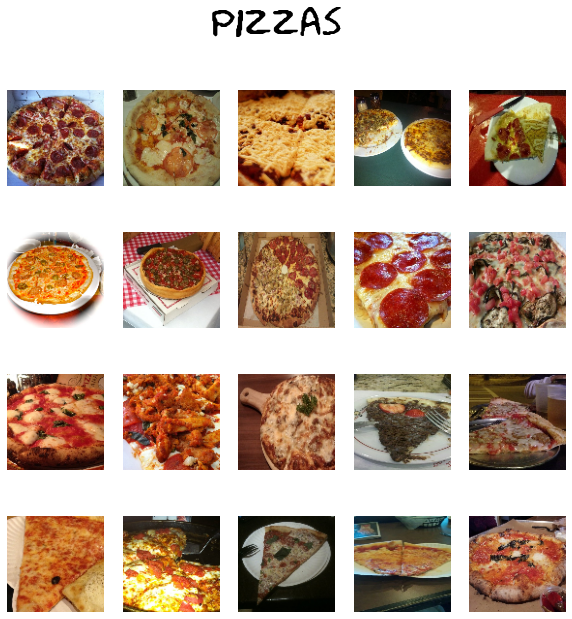

In [ ]:
# Visualizacion de pizzas
show_images(4, 5, pizzas_color, 'Pizzas', 'Humor Sans')

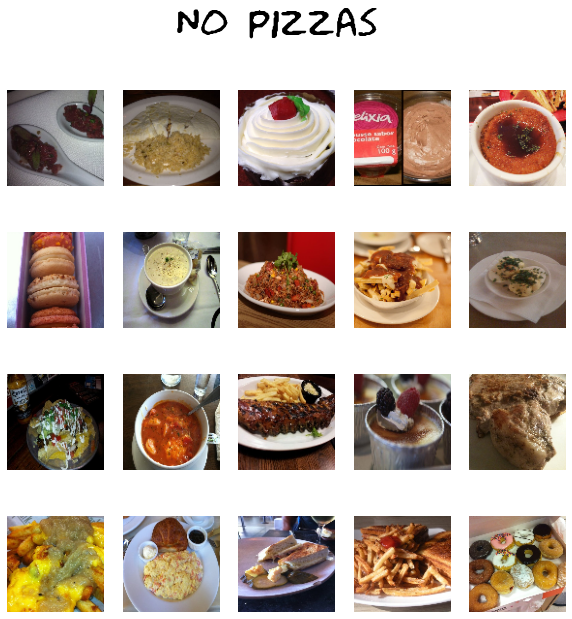

In [ ]:
# Visualizacion de no pizzas
show_images(4, 5, not_pizzas_color, 'No pizzas', 'Humor Sans')

### Canales

Empezamos a buscar un canal que nos permita entender donde ocurre la separación de elementos de las imágenes de manera más notable

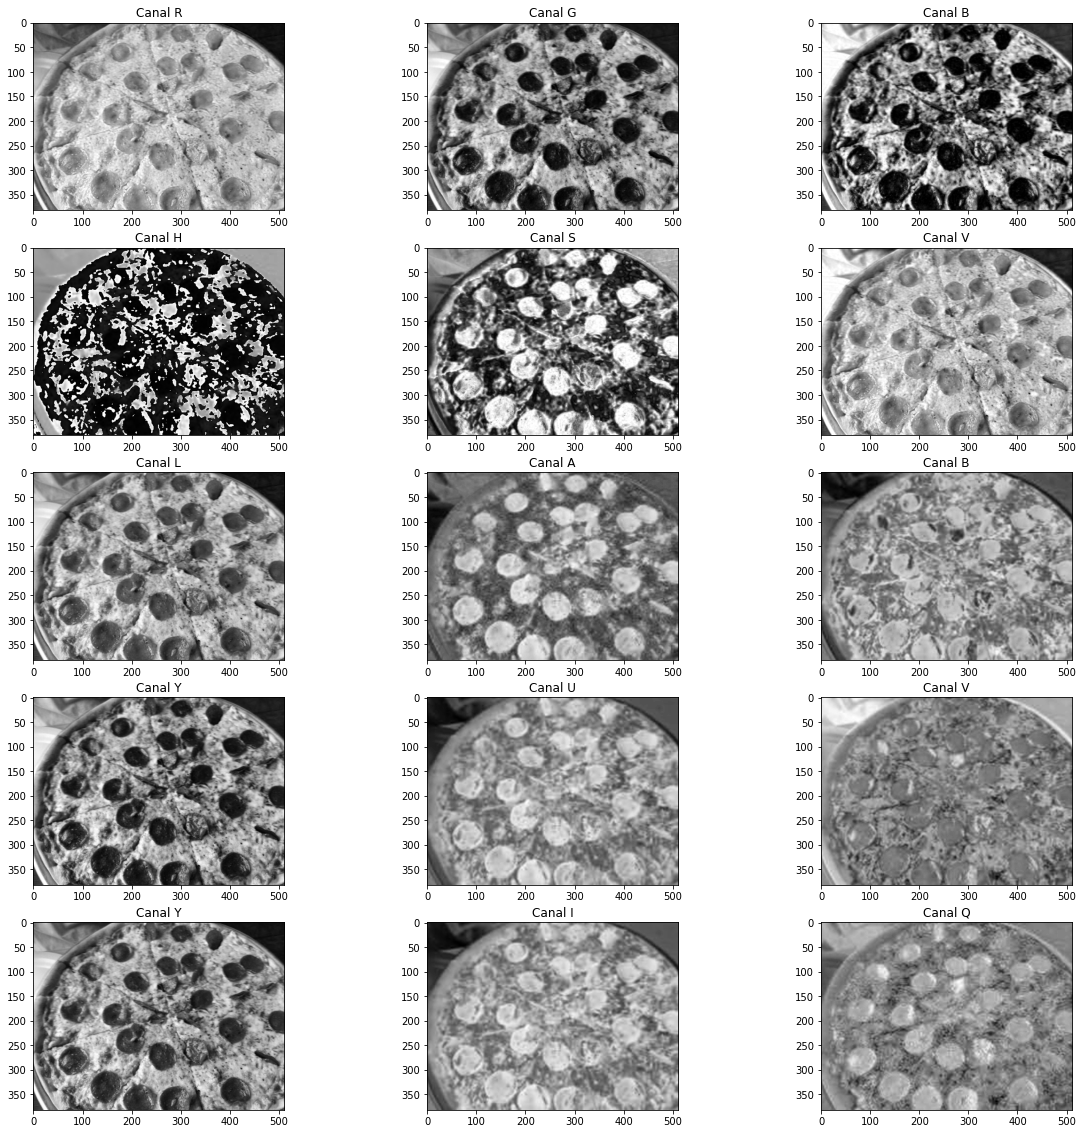

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/244505.jpg")
fig, ax = plt.subplots(5,3, figsize = (20,20))
#RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ax[0,0].imshow(img_rgb[:,:,0], cmap = "gray")
ax[0,0].set_title("Canal R")
ax[0,1].imshow(img_rgb[:,:,1], cmap = "gray")
ax[0,1].set_title("Canal G")
ax[0,2].imshow(img_rgb[:,:,2], cmap = "gray")
ax[0,2].set_title("Canal B")

#HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

ax[1,0].imshow(img_hsv[:,:,0], cmap = "gray")
ax[1,0].set_title("Canal H")
ax[1,1].imshow(img_hsv[:,:,1], cmap = "gray")
ax[1,1].set_title("Canal S")
ax[1,2].imshow(img_hsv[:,:,2], cmap = "gray")
ax[1,2].set_title("Canal V")

#LAB
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

ax[2,0].imshow(img_lab[:,:,0], cmap = "gray")
ax[2,0].set_title("Canal L")
ax[2,1].imshow(img_lab[:,:,1], cmap = "gray")
ax[2,1].set_title("Canal A")
ax[2,2].imshow(img_lab[:,:,2], cmap = "gray")
ax[2,2].set_title("Canal B")

#YUV
img_yuv  = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

ax[3,0].imshow(img_yuv[:,:,0], cmap = "gray")
ax[3,0].set_title("Canal Y")
ax[3,1].imshow(img_yuv[:,:,1], cmap = "gray")
ax[3,1].set_title("Canal U")
ax[3,2].imshow(img_yuv[:,:,2], cmap = "gray")
ax[3,2].set_title("Canal V")

#YIQ

img_Y = 0.299*img_rgb[:,:,0]+0.587*img_rgb[:,:,1]+0.144*img_rgb[:,:,2]
img_I = 0.596*img_rgb[:,:,0]-0.274*img_rgb[:,:,1]-0.322*img_rgb[:,:,2]
img_Q = 0.211*img_rgb[:,:,0]-0.523*img_rgb[:,:,1]+0.312*img_rgb[:,:,2]

ax[4,0].imshow(img_Y, cmap = "gray")
ax[4,0].set_title("Canal Y")
ax[4,1].imshow(img_I, cmap = "gray")
ax[4,1].set_title("Canal I")
ax[4,2].imshow(img_Q, cmap = "gray")
_ = ax[4,2].set_title("Canal Q")

### Extracción de características

Utilizaremos tres funciones para hallar las características que nos podrían servir en nuestras imágenes, cada una de ellas nos permitirá extraer ciertas características dentro de los siguientes tres criterios

*   Matriz de co-ocurrencia
*   Filtro de Gabor
*   Características generales


#### Matriz de co-ocurrencia
Obtenemos las matriz de co-ocurrencia de cada imagen leyendola en escala de grises. A partir de esta extraemos informacion acerca del objeto, de esta forma clasificando diferentes caracteristicas representativas.\
Tales como:
* Contraste
* Disimilitud
* Homogeneidad
* Energia
* Correlacion

Para hallar las anteriores características utilizaremos métodos definidos dentro de la matriz de nivel gris de co ocurrencias 

In [ ]:
def features_co_matrix(path):
  # Establecemos la imagen en escala de gris
  img = cv2.imread(path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Obtenemos la matriz de co-ocurrencia
  get_co_matrix = greycomatrix(img_gray, [2], [0], 256, symmetric=True, normed=True)

  # Caracteristicas de la matrix:
  contrast = greycoprops(get_co_matrix, prop="contrast")[0, 0]
  dissimilarity = greycoprops(get_co_matrix, prop="dissimilarity")[0, 0]
  homogeneity = greycoprops(get_co_matrix, prop="homogeneity")[0, 0]
  energy = greycoprops(get_co_matrix, prop="energy")[0, 0]
  correlation = greycoprops(get_co_matrix, prop="correlation")[0, 0]
  
  # Retornamos las caracteristicas
  return [contrast, dissimilarity, homogeneity, energy, correlation]

#### Filtro de Gabor
Es posible obtener caracteristicas claves de la imagen a partir del filtro de Gabor. Gracias a este podemos analizar ciertas particularidades de la textura de una imagen.
Se utiliza dos caracteristicas a partir de esta, las cuales son:
* Energia
* Entropia


In [ ]:
def features_gabor_filter(path):
  # Leemos la imagen en escala de gris
  img = cv2.imread(path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Obtenemos el filtro de la imagen
  gabor_filt_real, gabor_filt_img = gabor(img_gray, frequency=0.6)
  gabor_filter = (gabor_filt_real ** 2 + gabor_filt_img ** 2)//2
  
  # Calculo del histograma
  gabor_hist, _ = np.histogram(gabor_filter, 8)
  gabor_hist = np.array(gabor_hist, dtype=float)
  gabor_prob = np.divide(gabor_hist, np.sum(gabor_hist))
  gabor_energy = np.sum(gabor_prob ** 2)
  gabor_entropy = -np.sum(np.multiply(gabor_prob, np.log2(gabor_prob)))
  return [gabor_energy, gabor_entropy]

#### Caracteristicas generales de la imagen:


* Area
* Perimetro
* Cantidad de pepperonies  

Viendo los elementos que los canales de las imágenes nos permiten encontrar y viendo como esta compuesto el dataset, podemos encontrar tres principales características, área y perímetro por la forma en que estan compuestas la mayoría de imágenes, y también podemos ver como los pepperonis son una de los ingredientes más comunes en el dataset, por lo cual dichas características que son las que encontramos con más regularidad nos permitirán empezar a ver como se distribuyen en las imagénes, tanto las que son pizzas como las que no.  

La función además debe tener en cuenta las imágenes con las cuales haya problemas en la lectura, sea por como fueron guardadas dentro del dataset o por cualquier otro motivo, estas serán clasificadas como "" dentro del dataframe.

Para la extracción de características haremos una umbralización otsu, la cual nos permitirá eliminar el fondo o la mayoría de este. 
Para hallar el área utilizaremos countourArea(), para el perímetro utilizaremos arcLength() que nos permite hallar el perímetro del contorno y para hallar los pepperonis que estan en la pizza usaremos el canal A del LAB y utilizando morfología trateremos de hallar las figuras más similares a esta.

También sera desde esta función donde podremos acceder a las otras dos para las imágenes en nuestro dataset

In [ ]:
def feature_extractor(filename, label, quitar):

    try:
        main_img = cv2.imread(filename)
        img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    except:
        total_images.pop(quitar) #Quitamos de nuestra lista de total de imágenes aquellas que no fue posible leer
        return "Invalid"
    
    gabor_features = features_gabor_filter(filename)
    co_matrix_features = features_co_matrix(filename)

    gs = img[:,:,0]
    blur = cv2.GaussianBlur(gs, (25,25), 0)

    ret_otsu,im_bw_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 
    kernel = np.ones((25,25), np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

    # Area y perímetro
    contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    area = cv2.contourArea(cnt)
    if area==0:
        return "Invalid"
    perimeter = cv2.arcLength(cnt,True)

    current_frame = main_img
    filtered_image = closing/255

    img = cv2.imread(filename)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) #La volvemos a leer para usar el canal A

    _, thresh_1 = cv2.threshold(img1[:,:,1], 160, 255, cv2.THRESH_BINARY)

    kernel = morph.disk(5)
    apertura = cv2.morphologyEx(thresh_1, cv2.MORPH_OPEN, kernel, iterations = 2)

    contours, _ = cv2.findContours(apertura.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    l = [area, perimeter, len(contours), label]
    return l + co_matrix_features + gabor_features

Con esta función podremos aplicar las otras tres funciones definidas anteriomente a todas las imágenes del dataset

In [ ]:
def get_features(path, label, position = 0):
  list_directory = sorted(os.listdir(path))
  features = []
  for img_path in list_directory:
    img_feature = feature_extractor(os.path.join(path, img_path), label, position)
    features.append(img_feature)
    position += 1
  return features, position

Enumeramos las imagenes para poder acceder a ellas con mayor facilidad incluso si manipulamos los índices del dataframe

In [ ]:
pizza_features, new_position = get_features(path_pizza, "Pizza")
not_pizza_features, _ = get_features(path_not_pizza, "No Pizza", new_position)

Quitamos las imagenes que tenían área 0 o que por cualquier otro motivo dieron "invalid" en la extracción

In [ ]:
total_features = pizza_features + not_pizza_features
clean_features = list(filter(lambda x: x != "Invalid", total_features))
enum_features = [item + [idx] for idx, item in enumerate(clean_features)]

#### Muestra de la segmentación realizada

Miramos para una imagen en particular como queda la extracción de características

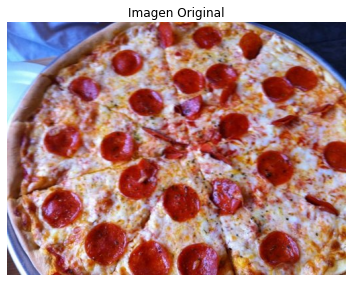

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/244505.jpg", 1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize = (5,5))

ax.imshow(img_rgb, cmap = "gray")
ax.set_axis_off()
ax.set_title("Imagen Original")

plt.tight_layout()

Area: 260.0
Perimeter: 79.79898953437805
Gabor_energy Gabor_entropy: [0.2008637567644942, 2.5841161648541786]
Contrast	Dissimilarity	Homogeneity	Energy	Correlation: [499.01681552202, 15.421517298018676, 0.09708361650176338, 0.010095952621623435, 0.9210605796983267]


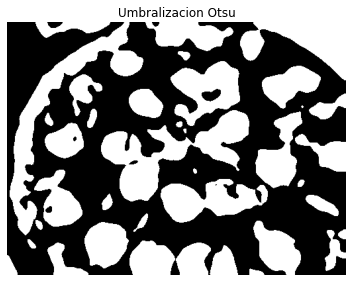

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/244505.jpg")
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) #La volvemos a leer para usar el canal A

gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gs, (25,25), 0)

ret_otsu,im_bw_otsu = cv2.threshold(blur, 0, 255, 
                                        cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 
kernel = np.ones((25,25), np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

contours, _ = cv2.findContours(closing, cv2.RETR_TREE,
                                   cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt,True)

gabor_features = features_gabor_filter("/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/244505.jpg")
co_matrix_features = features_co_matrix("/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/244505.jpg")

fig, ax = plt.subplots(figsize = (5,5))

print(f"Area: {area}" )
print(f"Perimeter: {perimeter}")
print(f"Gabor_energy Gabor_entropy: {gabor_features}")
print(f"Contrast	Dissimilarity	Homogeneity	Energy	Correlation: {co_matrix_features}")

ax.imshow(im_bw_otsu, cmap = "gray")
ax.set_axis_off()
ax.set_title("Umbralizacion Otsu")

plt.tight_layout()

Podemos ver como eliminamos el fondo en la umbralización otsu, algunos ingredientes pueden quedar incluidos dentro del cálculo de área y perímetro pero esto será proporcional para las pizzas por tener la mayoría ingredientes(la mayoría tienen ingredientes similares) por lo que no será un problema para la clasificación.

Total pepperonis encontrados: 24


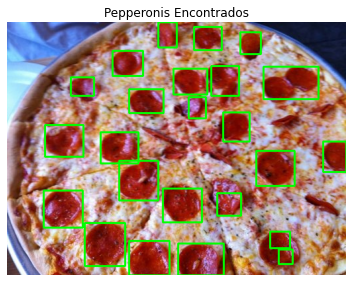

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Vision/pizza_not_pizza/pizza/244505.jpg")
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

_, thresh_1 = cv2.threshold(img1[:,:,1], 160, 255, cv2.THRESH_BINARY)

kernel = morph.disk(5)
apertura = cv2.morphologyEx(thresh_1, cv2.MORPH_OPEN, kernel, iterations = 2)

contours, hierarchy = cv2.findContours(apertura.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for i in contours:
  x,y,w,h = cv2.boundingRect(i)
  cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(0,255,0),2)

print(f"Total pepperonis encontrados: {len(contours)}")

fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(img_rgb, cmap = "gray")
ax.set_axis_off()
ax.set_title("Pepperonis Encontrados")
plt.tight_layout()

Podemos ver como el programa reconoce los pepperonis en las imagenes de manera casi que completamente acertada

#### Creación dataframe

Utilizando las características que encontramos anteriormente creamos el dataframe

In [ ]:
df_features = pd.DataFrame(
    columns=["Area", 
             "Perimetro", 
             "Pepperoni", 
             "Etiqueta", 
             "Contrast",
             "Dissimilarity",
             "Homogeneity",
             "Energy",
             "Correlation",
             "gabor_energy",
             "gabor_entropy",
              "Imagen"
    ],
    data=enum_features,
)
df_features_idx_image = df_features.set_index("Imagen")
df_features_idx_image

Area    Perimetro  Pepperoni  Etiqueta    Contrast  Dissimilarity  \
Imagen                                                                          
0           86.0    49.313708          4     Pizza  436.835417      13.739300   
1         1898.5   210.870057          0     Pizza  191.689910       8.384395   
2           98.5    48.727922          8     Pizza  137.456181       7.290640   
3        63447.0  1385.612260          0     Pizza  185.215594       6.762086   
4           33.5    29.556349          5     Pizza  212.350227       8.347344   
...          ...          ...        ...       ...         ...            ...   
1937    138637.0  3264.361602          0  No Pizza  408.007797      10.430836   
1938       641.0   113.740115          1  No Pizza  136.143536       5.503615   
1939     19363.5  1383.806130          2  No Pizza  446.264481      10.558895   
1940      1925.0   203.597979          0  No Pizza  166.029278       6.978065   
1941      4596.5   361.865007          0  No Pizza  263.926220       9.470573   

        Homogeneity    Energy  Correlation  gabor_energy  gabor_entropy  
Imagen                                                                   
0          0.121380  0.010741     0.936180      0.272149       2.360157  
1          0.174226  0.018430     0.917738      0.281925       1.965034  
2          0.179602  0.015676     0.980804      0.179380       2.631784  
3          0.301697  0.030056     0.981586      0.426396       1.899829  
4          0.194958  0.016358     0.968043      0.331767       2.068104  
...             ...       ...          ...           ...            ...  
1937       0.196171  0.015873     0.943443      0.386626       1.908886  
1938       0.329355  0.027340     0.980761      0.369784       1.966540  
1939       0.265712  0.037542     0.952569      0.346143       2.056719  
1940       0.296251  0.021678     0.971918      0.297820       2.199491  
1941       0.181368  0.014473     0.967963      0.307692       2.222985  

[1942 rows x 11 columns]

## Modelo de Aprendizaje

Para poder plantear un bueno modelo debemos tener en cuenta como se distribuyen las características que tenemos en el dataframe. Para ello graficaremos está información mediante gráficos de dispersión para comprobar si es posible implementar un modelo basado en los k-vecinos, y también haremos matrices de correlación para ver como se comportan las características pensando en cada una de las etiquetas para pensarse en soluciones alternas

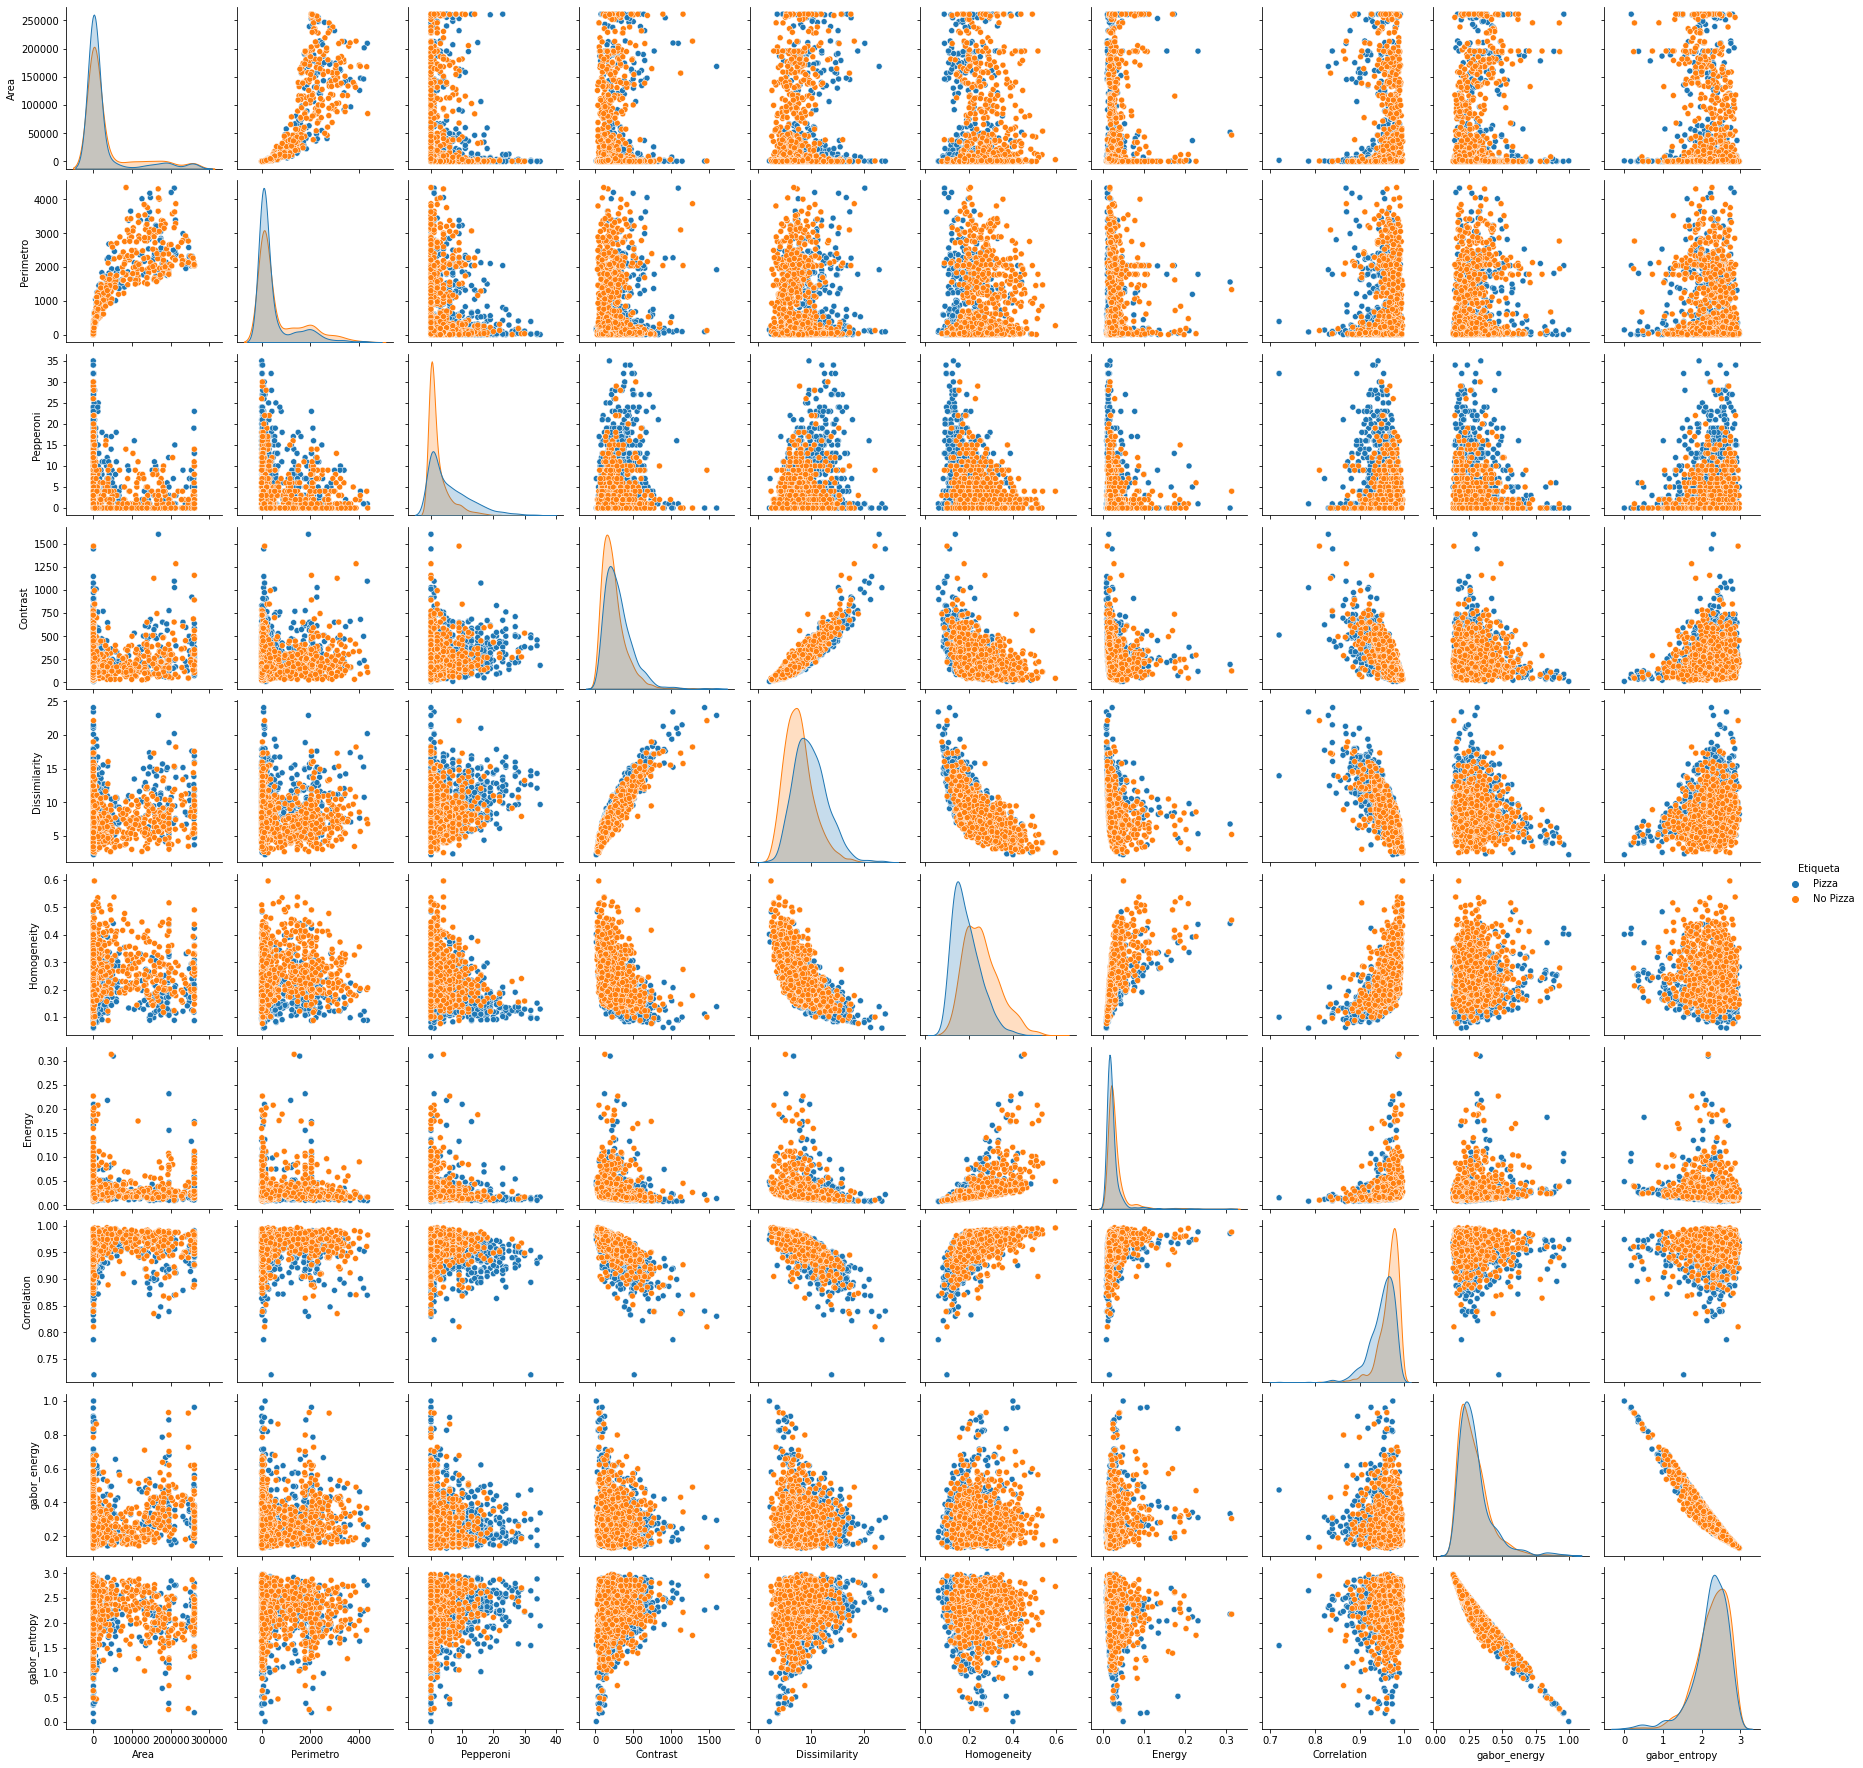

In [ ]:
_ = sns.pairplot(df_features_idx_image, hue="Etiqueta")

#### Prueba k-vecinos

Realizamos una prueba para probar nuestra intuición de que el método de los k-vecinos no es la mejor opción en este caso porque para la gran mayoría de características no existe suficiente separación entre cada una de las categorías en sus diferentes características

In [ ]:
from sklearn.model_selection import train_test_split
x_vecinos = df_features_idx_image.drop("Etiqueta", axis = 1)
y_vecinos = df_features["Etiqueta"]

X_train, X_test, y_train, y_test = train_test_split(x_vecinos, y_vecinos, random_state=0)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2)

In [ ]:
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))

Test set accuracy: 0.55


Vemos como nos da un resultado relativamente bajo para el numero de características y el tamaño del dataset que tenemos, por lo cual empezamos a buscar métodos alternativos

#### Conclusión gráfico

Con el gráfico anterior podemos ver que debemos descartar el método de los k-veciones más cercanos, encontrar una frontera de decisión para cada una de las características que logré una separación óptima para ambas categorías, se ve puede ver tanto en el scatter plot como en los resultados de precisión de las imágenes de validación, que no es lo más ideal. Por el contrario si podemos ver como es más común encontrar valores altos de las características para las pizzas que para las no pizzas. Con lo anterior descartado, podemos pensar como modelos alternos, random forest, teniendo sus ventajas y desventajas que veremos al momento de ser desarrollado, para lo cual haremos las matrices de correlación y poder ver si hay alguna característica que tenemos que descartar

#### Matrices de correlación

In [ ]:
pizzas = df_features_idx_image.drop(df_features_idx_image[df_features_idx_image["Etiqueta"] == "No Pizza"].index)

In [ ]:
no_pizzas = df_features_idx_image.drop(df_features_idx_image[df_features_idx_image["Etiqueta"] == "Pizza"].index)

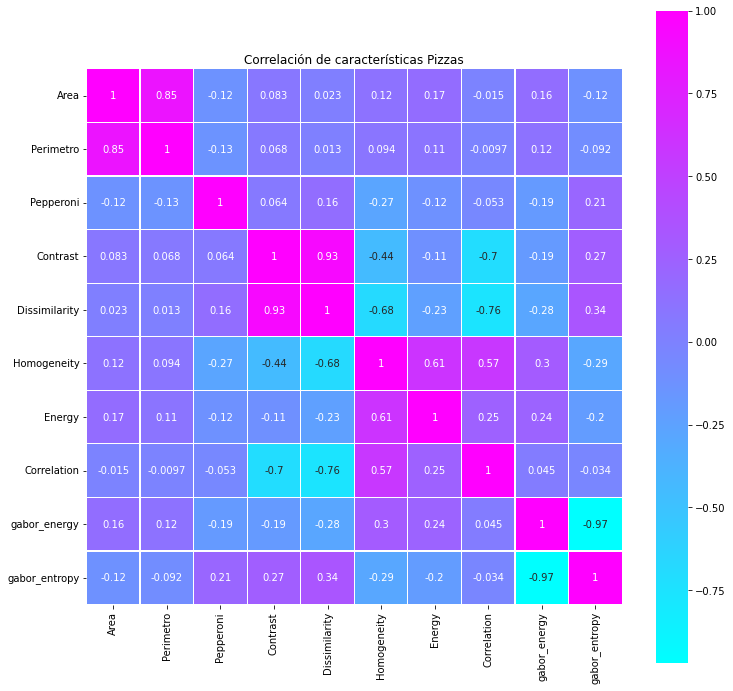

In [ ]:
colormap = plt.cm.cool
plt.figure(figsize=(12,12))
plt.title('Correlación de características Pizzas')
# se utiliza la funcion heatmap para representar de forma visual el mapa de correlacion de pearson
sns.heatmap(pizzas.drop('Etiqueta', axis=1).astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

plt.show()

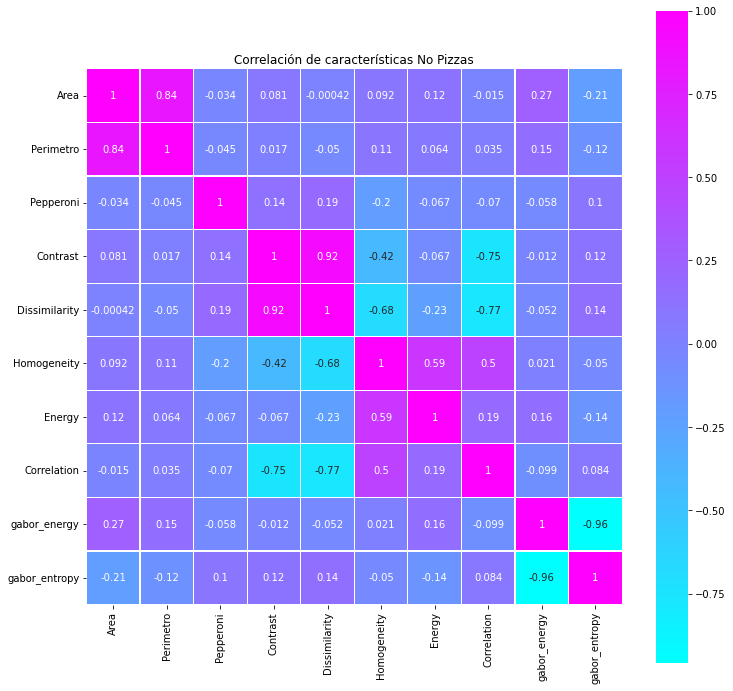

In [ ]:
colormap = plt.cm.cool
plt.figure(figsize=(12,12))
plt.title('Correlación de características No Pizzas')
# se utiliza la funcion heatmap para representar de forma visual el mapa de correlacion de pearson
sns.heatmap(no_pizzas.drop('Etiqueta', axis=1).astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

plt.show()

Con ambas matrices de correlación podemos ver como la mayoría de características no tienen una relación dependiente entre ellas por tanto no nos llevarían a un modelo sobredefinido, por tanto las que quitaremos serán:

*   Perimetro
*   Dissimilarity

Que son las características que presentan una fuerte relación lineal entre ellas para ambas características

In [ ]:
df_features_idx_image.drop("Perimetro", axis = 1, inplace = True)

In [ ]:
df_features_idx_image.drop("Dissimilarity", axis = 1, inplace = True)

In [ ]:
df_features_idx_image

Area  Pepperoni  Etiqueta    Contrast  Homogeneity    Energy  \
Imagen                                                                     
0           86.0          4     Pizza  436.835417     0.121380  0.010741   
1         1898.5          0     Pizza  191.689910     0.174226  0.018430   
2           98.5          8     Pizza  137.456181     0.179602  0.015676   
3        63447.0          0     Pizza  185.215594     0.301697  0.030056   
4           33.5          5     Pizza  212.350227     0.194958  0.016358   
...          ...        ...       ...         ...          ...       ...   
1937    138637.0          0  No Pizza  408.007797     0.196171  0.015873   
1938       641.0          1  No Pizza  136.143536     0.329355  0.027340   
1939     19363.5          2  No Pizza  446.264481     0.265712  0.037542   
1940      1925.0          0  No Pizza  166.029278     0.296251  0.021678   
1941      4596.5          0  No Pizza  263.926220     0.181368  0.014473   

        Correlation  gabor_energy  gabor_entropy  
Imagen                                            
0          0.936180      0.272149       2.360157  
1          0.917738      0.281925       1.965034  
2          0.980804      0.179380       2.631784  
3          0.981586      0.426396       1.899829  
4          0.968043      0.331767       2.068104  
...             ...           ...            ...  
1937       0.943443      0.386626       1.908886  
1938       0.980761      0.369784       1.966540  
1939       0.952569      0.346143       2.056719  
1940       0.971918      0.297820       2.199491  
1941       0.967963      0.307692       2.222985  

[1942 rows x 9 columns]

Por tanto el modelo que elegiremos será el de random forest, debido a que nos ayudará a evitar tener un modelo sobredefinido, y tener varios arboles de decisión nos permitirá además que por la manera en que se definen con sus nodos y los resultados que se van desprendiendo de cada uno según la profundidad del árbol nos permitirá encontrar aquellas imágenes con los valores más altos en las características

#### Random Forest

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [ ]:
x = df_features_idx_image.drop("Etiqueta", axis = 1)
y = df_features["Etiqueta"]

Dividiremos toda nuestra información en dos, la que utilizaremos para entrenar el modelo, el 80% de las imágenes, y para validar que tan bien se hizo el aprendizaje, el 20%. Donde X_train y X_test contendrán toda la información pero no si corresponde a una pizza 0 no, además y_test y y_train contendrán las respectivas etiquetas de pizza o no pizza

In [ ]:
sc = StandardScaler()
X_scaled = sc.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y,
    stratify=y,
    test_size=0.20,
    random_state=45
)

Utilizamos la librería scikit para crear el Random Forest, y lo configuramos con los siguientes parámetros:

**accuracy_score**: Ver el desempeño de nuestro modelo

**Random Forest Classifier:** Nos permite crear el Random Forest y definir sus parámetros que ayudarán a que el proceso de aprendizaje del modelo ocurra de mejor manera

**train_test_split:** Se encarga de dividir las imágenes en train y test, según una proporción que podemos definir y otros parámtros

In [ ]:
classifier = RandomForestClassifier(
  n_estimators=100, 
  random_state=65, 
  max_depth = 5
)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=65)

In [ ]:
y_pred = classifier.predict(X_test)

Verificamos la precisión del modelo con imágenes que no había visto anteriormente

In [ ]:
print("Precisión: {:.3f}".format(accuracy_score(y_test, y_pred)))

Precisión: 0.771


In [ ]:
def prediccion(posicion):

  idx_img = y_test.index[posicion]
  fig, ax = plt.subplots(figsize = (4,4))
  ax.imshow(total_images[idx_img], cmap = "gray")
  ax.set_axis_off()
  ax.set_title(y_pred[posicion], fontsize = 25)
  plt.tight_layout()

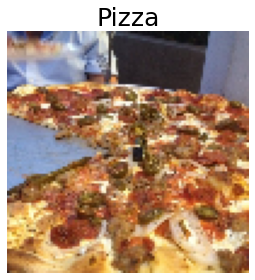

In [ ]:
prediccion(10)

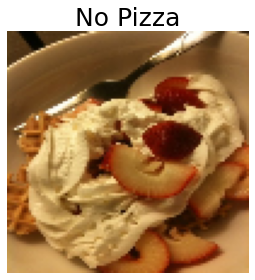

In [ ]:
prediccion(120)

In [ ]:
# verificar características importantes
feature_importances_df = pd.DataFrame(
    {"feature": list(x.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

# Mostrar
feature_importances_df

feature  importance
3    Homogeneity    0.269897
5    Correlation    0.185836
1      Pepperoni    0.151293
4         Energy    0.144368
7  gabor_entropy    0.075764
6   gabor_energy    0.065523
2       Contrast    0.059700
0           Area    0.047619

## Ideas Finales

### Comparación de resultados

Para la solución del problema planteamos varias soluciones, donde muchas veces nos encontramos con la situación de tener que sacrificar algo en el rendimiento del programa o en sus resultados. A continuación podemos ver cuales fueron esas situaciones y porque decidimos irnos por uno de los diferentes enfoques que teníamos

#### Extracción de características



Inicialmente teníamos menos carcaterísticas que las que presentamos en esta última versión, al momento de empezar a extraer un mayor número de características empezamos a ver como hubo mejores resultados en la precisión del modelo, lo cual nos muestra como realizar un pre procesamiento de las imágenes mucho más profundo nos puede llevar a tener mejores ideas de que modelo de aprendizaje podemos plantear y mejora los resultados del mismo ya que incluso aplicando Random Forest en ambos casos, cuando aumentamos el número de características tuvimos una mejoría de más del 10%

También es importante resaltar que un mayor número de características implica un mayor tiempo en la ejecución, sin embargo en este caso no fue significativo, por lo cual termino siendo más conveniente tener este mayor número de características.

A futuro si se quiere seguir mejorando el modelo bajo la misma idea de aumentar el número de características extraídas será importante tener en cuenta si el aumento del tiempo vale la pena por el aumento en la precisión, siendo la posibilidad de usar GPU como la que Google Colab dispone, una posible solución a este problema

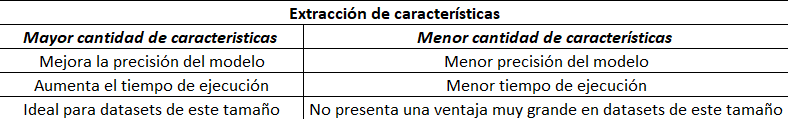


**Nota:** Respecto al tercer punto del cuadro comparativo, eso no signfica que siempre se deban usar un enfoque siempre para datasets pequeños u el otro para datasets grandes, simplemente fue lo que concluimos para este dataset con el tamaño específico que tiene y la cantidad de características específicas que decidimos extraer, siempre habrá que mirar como está compuesto el dataset para tomar una deicisón

#### Modelo de aprendizaje

Podemos ver como el random Forest nos permitió alcanzar muchos mejores resultados que el modelo que habíamos probado con los k-vecinos más cercanos. Siendo ambos modelos rápidos al ser ejecutados encontramos que para afrontar el problema fue mucha mejor opción el random forest ya que si recordamos los gráficos de las características podemos ver como no era fácil dibujar fronteras de decisión para las características, y aprovechando el número de características que teníamos y la posibilidad de decidir el número de arboles que queremos, se presentó como una solución mucho mejor lo cual se evidenció en los resultados. 

Esto nos muestra la importancia de saber como se distribuyen las características que extraemos para saber que modelo puede resultar una mejor opción desde el inicio, y esto, unido a las matrices de correlación que son muy útiles para modelos como el Random Forest nos permiten conocer mejor los motivos por los cuales debemos irnos por un modelo y que características debemos usar para el mismo

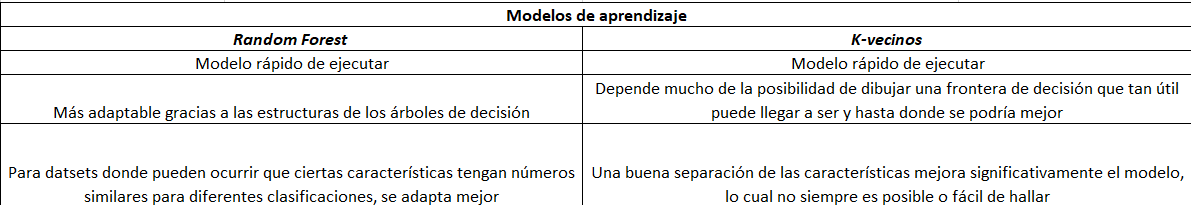

También si se quiere pensar en mejorar los resultados a futuro, otra opción es aumentar el tamaño del dataset para conseguir aún más información que permita mejorar los resultados de las predicciones

### Conclusiones



1.   El pre procesamiento de las imágenes se nos muestra como una de las partes claves para la construcción del programa ya que tiene un impacto directo en los resultados que podemos alcanzar, como lo fue en este caso, para la predicción de imágenes. La variedad de posibilidades que se puede hacer en esta fase nos muestra porque también debemos conocer como está compuestro nuestro dataset y saber extraer que características puede sernos más útil

2.   Incluso si tenemos la posibilidad de armar diferentes modelos de clasificación binaria, no todos son igual de útiles para todas las situaciones y es conocer el funcionamiento detrás de estos modelos (busqueda de cercanos en los k vecinos, y los nodos en los árboles de decisión) lo que nos permite saber cual nos permite alcanzar resultados eficientes al afrontar el problema

3.   No siempre podremos encontrar una solución donde alcancemos la mayor rapidez y precisión en la solución, pudimos evidenciar varias veces en este trabajo como muchas veces mejorar una signfica empeorar otra, por tanto debemos saber cuales son los criterios que nos pueden ayudar a tomar la decisión óptima según lo que podemos hacer y lo que queramos lograr

